# Metodologia para Avaliação de Overhead em HPC usando DGEMM no Docker

Este _notebook_ organiza a metodologia para quantificar o _overhead_ (sobrecarga), introduzido pelo uso de containers Docker, na execução de aplicações de alto desempenho. Com esta finalidade é utilizada uma aplicação baseadas na operação DGEMM, comparando o desempenho de sua exeução no container com a execução nativa no sistema operacional.

## 1. Introdução

O objetivo deste estudo é quantificar o _overhead_ introduzido pelo Docker em aplicações de alto desempenho, usando como base um benchmark de DGEMM. São consideradas diferentes combinações de:

- Implementações de BLAS (por exemplo, OpenBLAS, BLIS)
- Implementação sequencial e com multiplas _threads_
- Tamanhos de matrizes
- Execução em ambiente **nativo** vs. **Docker**

As métricas coletadas em cada execução são:

- Tempo de execução
- Desempenho em FLOPS ou GFLOPS (Operações de ponto flutuante por segundo)

A partir dessas métricas, serão definidas expressões para calcular o _overhead_ em termos de tempo e desempenho, bem como procedimentos estatísticos para garantir robustez na análise.


In [7]:
# Carregar e inspecionar dados brutos
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Adicionar caminho do script de análise
sys.path.append('..')
from analysis_benchmark_hpc import load_data, calculate_overhead, calculate_gflops

# Configuração
base_path = '../output'
threading_mode = 'single'  # single-thread
run_number = '001'

# Variantes BLAS para análise
variants = ['OpenBLAS64', 'BLIS64']
environments = ['native', 'docker']
methods = ['alternatives', 'direct_compilation']

# Carregar dados de todas as combinações
all_data = []
for variant in variants:
    for env in environments:
        for method in methods:
            df = load_data(base_path, threading_mode, env, method, variant, run_number)
            if df is not None:
                df['variant'] = variant
                df['environment'] = env
                df['method'] = method
                all_data.append(df)

# Combinar todos os dados
df_combined = pd.concat(all_data, ignore_index=True)

print(f'Total de registros carregados: {len(df_combined)}')
print(f'Colunas disponíveis: {list(df_combined.columns)}')
print('\nPrimeiras 20 linhas:')
df_combined.head(20)

Total de registros carregados: 64
Colunas disponíveis: ['matSize', 'Size', 'Mean', 'Variance', 'Largest', 'Smallest', 'Median', 'SD', 'SD_Mean', 'Skew', 'RMS', 'Kurtosis', 'variant', 'environment', 'method']

Primeiras 20 linhas:


,matSize,Size,Mean,Variance,Largest,Smallest,Median,SD,SD_Mean,Skew,RMS,Kurtosis,variant,environment,method
0,128,0.0042,0.0001,0.0,0.0001,0.0002,0.0001,0.0001,0.0000,1.0733,0.0001,-0.9200,OpenBLAS64,native,alternatives
1,256,0.0337,0.0007,0.0,0.0006,0.0009,0.0006,0.0001,0.0001,1.0642,0.0007,-0.9308,OpenBLAS64,native,alternatives
2,384,0.1135,0.0021,0.0,0.0020,0.0023,0.0021,0.0001,0.0001,0.9470,0.0021,-1.0685,OpenBLAS64,native,alternatives
3,512,0.2690,0.0055,0.0,0.0053,0.0058,0.0054,0.0002,0.0001,0.2737,0.0055,-2.0423,OpenBLAS64,native,alternatives
4,640,0.5251,0.0100,0.0,0.0098,0.0107,0.0099,0.0004,0.0002,1.0410,0.0101,-0.9612,OpenBLAS64,native,alternatives
5,768,0.9071,0.0168,0.0,0.0167,0.0170,0.0168,0.0001,0.0001,0.9004,0.0168,-1.1038,OpenBLAS64,native,alternatives
6,896,1.4403,0.0263,0.0,0.0262,0.0265,0.0263,0.0001,0.0000,0.2004,0.0263,-1.6051,OpenBLAS64,native,alternatives
7,1024,2.1496,0.0429,0.0,0.0427,0.0430,0.0429,0.0001,0.0001,-0.2181,0.0429,-1.9078,OpenBLAS64,native,alternatives
8,128,0.0042,0.0006,0.0,0.0001,0.0025,0.0001,0.0011,0.0005,1.0733,0.0011,-0.9200,OpenBLAS64,native,direct_compilation
9,256,0.0337,0.0008,0.0,0.0006,0.0010,0.0007,0.0002,0.0001,0.8692,0.0008,-1.1624,OpenBLAS64,native,direct_compilation


## 2. Desenho Experimental

Os experimentos são organizados conforme os seguintes fatores:

### 2.1 Ambientes comparados
- Execução **nativa** no sistema operacional (host).
- Execução **em container Docker**, mantendo o máximo de equivalência possível:
  - Mesma implementação de BLAS
  - Mesmo compilador e flags de compilação
  - Mesma versão do benchmark

### 2.2 Fatores de variação
- Implementações BLAS: OpenBLAS, BLIS, etc.
- Tamanhos de matriz: 32, 64, ..., 4096, aumentando o tamanho de 32 em 32

### 2.3 Repetições
Para cada combinação de parâmetros (BLAS, número de *threads*, tamanho da matriz, ambiente), o benchmark deve ser executado
múltiplas vezes (por exemplo, \( n = 5 \)), registrando-se o tempo de execução e o desempenho em GFLOPS.

Essas repetições permitem estimar média, desvio padrão, intervalos de confiança e significância estatística das diferenças
entre o ambiente nativo e o Docker.


In [8]:
# Implementar leitura e organização dos resultados experimentais
# Agrupar dados por (BLAS, método, tamanho da matriz, ambiente)
group_cols = ['variant', 'method', 'matSize', 'environment']
df_grouped = df_combined.groupby(group_cols)

# Estatísticas descritivas
print("Estatísticas descritivas do tempo médio de execução:")
df_grouped['Mean'].describe()

Estatísticas descritivas do tempo médio de execução:


count    mean  std     min  \
variant    method             matSize environment                               
BLIS64     alternatives       128     docker         1.0  0.0001  NaN  0.0001   
                                      native         1.0  0.0002  NaN  0.0002   
                              256     docker         1.0  0.0007  NaN  0.0007   
                                      native         1.0  0.0007  NaN  0.0007   
                              384     docker         1.0  0.0022  NaN  0.0022   
...                                                  ...     ...  ...     ...   
OpenBLAS64 direct_compilation 768     native         1.0  0.0171  NaN  0.0171   
                              896     docker         1.0  0.0269  NaN  0.0269   
                                      native         1.0  0.0263  NaN  0.0263   
                              1024    docker         1.0  0.0423  NaN  0.0423   
                                      native         1.0  0.0426  NaN  0.0426   

                                                      25%     50%     75%  \
variant    method             matSize environment                           
BLIS64     alternatives       128     docker       0.0001  0.0001  0.0001   
                                      native       0.0002  0.0002  0.0002   
                              256     docker       0.0007  0.0007  0.0007   
                                      native       0.0007  0.0007  0.0007   
                              384     docker       0.0022  0.0022  0.0022   
...                                                   ...     ...     ...   
OpenBLAS64 direct_compilation 768     native       0.0171  0.0171  0.0171   
                              896     docker       0.0269  0.0269  0.0269   
                                      native       0.0263  0.0263  0.0263   
                              1024    docker       0.0423  0.0423  0.0423   
                                      native       0.0426  0.0426  0.0426   

                                                      max  
variant    method             matSize environment          
BLIS64     alternatives       128     docker       0.0001  
                                      native       0.0002  
                              256     docker       0.0007  
                                      native       0.0007  
                              384     docker       0.0022  
...                                                   ...  
OpenBLAS64 direct_compilation 768     native       0.0171  
                              896     docker       0.0269  
                                      native       0.0263  
                              1024    docker       0.0423  
                                      native       0.0426  

[64 rows x 8 columns]

## 3. Definição das Métricas de _Overhead_

A avaliação do _overhead_ será feita a partir de duas métricas principais:

- _Overhead_ no tempo de execução
- _Overhead_ no desempenho (GFLOPS)

Para cada configuração $(\text{BLAS}, N)$, serão comparados os resultados nos ambientes **host** (nativo) e **Docker**.

### 3.1 _Overhead_ em tempo de execução

Sejam:

- $( T_{\text{host}} )$: tempo médio de execução no sistema nativo
- $( T_{\text{dock}} )$: tempo médio de execução no Docker

Define-se o _overhead_ percentual em tempo como:

$\text{Overhead}_{\text{tempo}} = \left( \frac{T_{\text{dock}} - T_{\text{host}}}{T_{\text{host}}} \right) \times 100\%.$ 

Também é útil definir o fator de *slowdown*:

$ \text{Slowdown} = \frac{T_{\text{dock}}}{T_{\text{host}}}.$

Valores de *slowdown* maiores que 1 indicam que a execução em Docker é mais lenta que a nativa.

### 3.2 _Overhead_ em desempenho (GFLOPS)

Sejam:

- $ P_{\text{host}} $: desempenho médio em GFLOPS no sistema nativo
- $ P_{\text{dock}} $: desempenho médio em GFLOPS no Docker

Define-se o _overhead_ em termos de desempenho como:

$ \text{Overhead}_{\text{GFLOPS}} = \left( \frac{P_{\text{host}} - P_{\text{dock}}}{P_{\text{host}}} \right) \times 100\%.$

Valores positivos indicam perda de desempenho ao usar Docker; valores próximos de zero indicam diferença desprezível.


In [9]:
# Calcular overhead de tempo e GFLOPS a partir dos dados agregados

# Pivot para comparar native vs docker
df_pivot = df_combined.pivot_table(
    index=['variant', 'method', 'matSize'],
    columns='environment',
    values='Mean',
    aggfunc='first'
).reset_index()

# Calcular overhead usando função existente
df_pivot['overhead_tempo_percent'] = df_pivot.apply(
    lambda row: calculate_overhead(row['native'], row['docker'])[0], axis=1
)
df_pivot['overhead_tempo_abs'] = df_pivot.apply(
    lambda row: calculate_overhead(row['native'], row['docker'])[1], axis=1
)
df_pivot['slowdown'] = df_pivot['docker'] / df_pivot['native']

# Calcular GFLOPS
df_pivot['gflops_native'] = df_pivot.apply(
    lambda row: calculate_gflops(row['matSize'], row['native']), axis=1
)
df_pivot['gflops_docker'] = df_pivot.apply(
    lambda row: calculate_gflops(row['matSize'], row['docker']), axis=1
)
df_pivot['overhead_gflops_percent'] = (
    (df_pivot['gflops_native'] - df_pivot['gflops_docker']) / df_pivot['gflops_native'] * 100
)

print("\nOverhead calculado (primeiras 15 linhas):")
df_pivot[['variant', 'method', 'matSize', 'overhead_tempo_percent', 
          'overhead_gflops_percent', 'slowdown']].head(15)


Overhead calculado (primeiras 15 linhas):


environment,variant,method,matSize,overhead_tempo_percent,overhead_gflops_percent,slowdown
0,BLIS64,alternatives,128,-50.000000,-100.000000,0.500000
1,BLIS64,alternatives,256,0.000000,0.000000,1.000000
2,BLIS64,alternatives,384,-4.347826,-4.545455,0.956522
3,BLIS64,alternatives,512,0.000000,0.000000,1.000000
4,BLIS64,alternatives,640,2.970297,2.884615,1.029703
5,BLIS64,alternatives,768,1.754386,1.724138,1.017544
6,BLIS64,alternatives,896,0.000000,0.000000,1.000000
7,BLIS64,alternatives,1024,2.663438,2.594340,1.026634
8,BLIS64,direct_compilation,128,29.629630,22.857143,1.296296
9,BLIS64,direct_compilation,256,10.000000,9.090909,1.100000


## 4. Tratamento Estatístico

Para cada combinação de parâmetros e ambiente, será feita uma análise estatística básica dos resultados,
incluindo cálculo de médias, desvios padrão, intervalos de confiança e testes de significância.

### 4.1 Cálculo de média e variabilidade

Sejam $ x_1, x_2, \ldots, x_n $ as observações (por exemplo, tempos de execução de $ n $ repetições).

A média amostral é dada por:

$ \overline{x} = \frac{1}{n} \sum_{i=1}^{n} x_i,$

e o desvio padrão amostral é:

$ \sigma = \sqrt{ \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \overline{x})^2 }. $

Essas quantidades podem ser calculadas tanto para tempo de execução quanto para GFLOPS, em cada ambiente.

### 4.2 Intervalos de confiança (opcional)

Supondo distribuição aproximadamente normal das médias, um intervalo de confiança de 95% para a média pode ser escrito como:

$ IC = \overline{x} \pm t_{\alpha/2} \cdot \frac{\sigma}{\sqrt{n}}, $

onde $ t_{\alpha/2} $ é o valor crítico da distribuição t de Student.

### 4.3 Testes de significância

Para verificar se as diferenças entre host e Docker são estatisticamente significativas, podem ser utilizados:

- Teste t pareado (se as suposições de normalidade forem razoáveis)
- Testes não-paramétricos, como Wilcoxon, se necessário

Essa análise ajuda a distinguir diferenças reais de flutuações devido a ruído ou variabilidade do sistema.


In [10]:
# Implementar cálculos estatísticos (médias, desvios, IC, testes de hipótese)
from scipy import stats

# Estatísticas resumidas por variante e método
overhead_stats = df_pivot.groupby(['variant', 'method']).agg({
    'overhead_tempo_percent': ['mean', 'std', 'median', 'min', 'max'],
    'overhead_gflops_percent': ['mean', 'std', 'median', 'min', 'max'],
    'slowdown': ['mean', 'std', 'median', 'min', 'max']
})

print("Estatísticas de Overhead por Biblioteca e Método:")
print(overhead_stats.round(4))

# Função para calcular intervalo de confiança
def calculate_ci(data, confidence=0.95):
    n = len(data)
    if n < 2:
        return None, None
    mean = np.mean(data)
    stderr = stats.sem(data)
    ci = stderr * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - ci, mean + ci

# Intervalos de confiança (95%)
print("\nIntervalos de Confiança 95% - Overhead de Tempo:")
for variant in variants:
    for method in methods:
        mask = (df_pivot['variant'] == variant) & (df_pivot['method'] == method)
        data = df_pivot[mask]['overhead_tempo_percent'].values
        if len(data) > 1:
            ci_lower, ci_upper = calculate_ci(data)
            mean = np.mean(data)
            print(f"{variant:15} - {method:20}: μ = {mean:6.3f}%, IC 95% = [{ci_lower:6.3f}%, {ci_upper:6.3f}%]")

# Testes de hipótese: teste t pareado
print("\nTestes de Significância (Native vs Docker):")
for variant in variants:
    for method in methods:
        mask = (df_combined['variant'] == variant) & (df_combined['method'] == method)
        native_data = df_combined[mask & (df_combined['environment'] == 'native')].sort_values('matSize')
        docker_data = df_combined[mask & (df_combined['environment'] == 'docker')].sort_values('matSize')
        
        native_times = native_data['Mean'].values
        docker_times = docker_data['Mean'].values
        
        if len(native_times) > 1 and len(docker_times) > 1 and len(native_times) == len(docker_times):
            t_stat, p_value = stats.ttest_rel(native_times, docker_times)
            significant = "Sim (p<0.05)" if p_value < 0.05 else "Não"
            print(f"{variant:<15} {method:<20} t={t_stat:8.4f}, p={p_value:8.6f} - Significativo: {significant}")

Estatísticas de Overhead por Biblioteca e Método:
environment                   overhead_tempo_percent                   \
                                                mean      std  median   
variant    method                                                       
BLIS64     alternatives                      -5.8700  17.9772  0.0000   
           direct_compilation                11.1411   8.8437  9.5455   
OpenBLAS64 alternatives                      -0.1076   1.0072  0.0000   
           direct_compilation                 3.2891  13.1069  0.5848   

environment                                     overhead_gflops_percent  \
                                   min      max                    mean   
variant    method                                                         
BLIS64     alternatives       -50.0000   2.9703                -12.1678   
           direct_compilation  -1.8182  29.6296                  9.5496   
OpenBLAS64 alternatives        -1.8182   1.0000                

## 5. Apresentação dos Resultados

### 5.1 Tabelas sugeridas

Uma forma clara de apresentar os resultados é usar tabelas que agreguem as métricas principais para cada combinação de parâmetros.
Por exemplo:

| BLAS | Threads | N | $T_{\text{host}}$ | $T_{\text{dock}}$ | Overhead tempo (%) | $P_{\text{host}}$ | $P_{\text{dock}}$ | Overhead GFLOPS (%) |
|------|---------|---|--------------------|--------------------|--------------------|--------------------|--------------------|----------------------|
| ...  |   ...   |...|        ...         |        ...         |        ...         |        ...         |        ...         |         ...          |

### 5.2 Gráficos sugeridos

Alguns gráficos que ajudam a visualizar o comportamento do overhead:

- Overhead de tempo (%) em função do tamanho da matriz \( N \)
- Overhead de tempo (%) em função do número de *threads*
- Comparação do overhead entre diferentes implementações de BLAS

Esses gráficos podem ser construídos tanto para tempo quanto para GFLOPS.


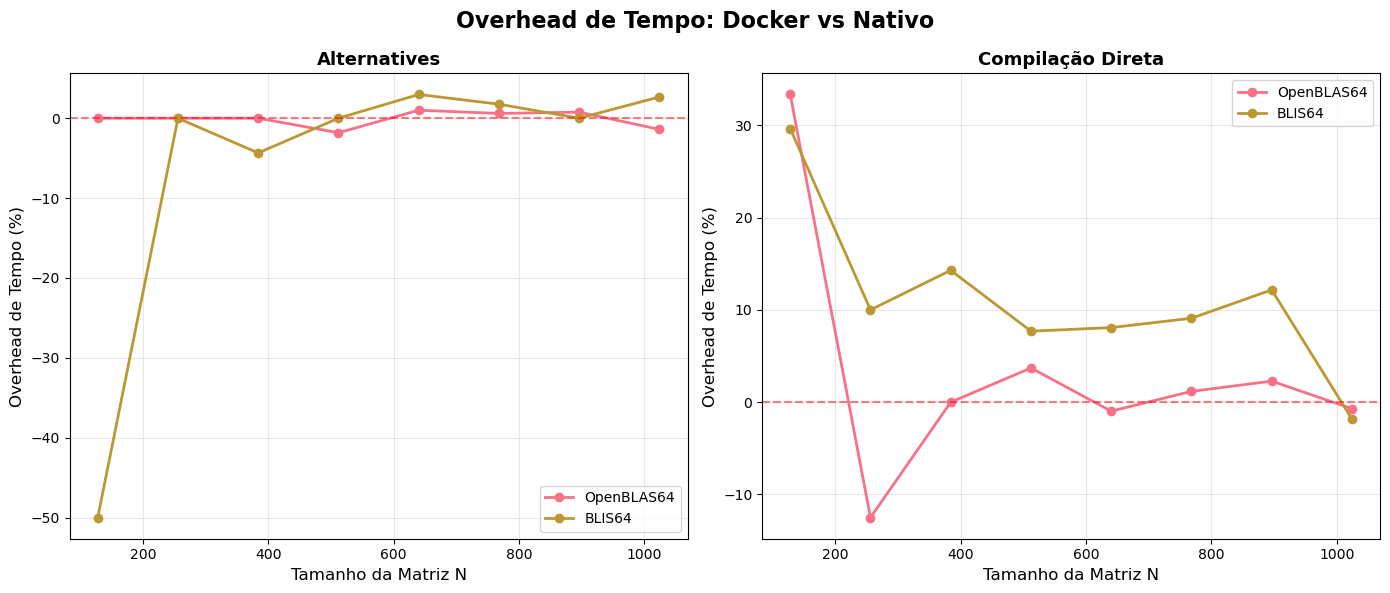

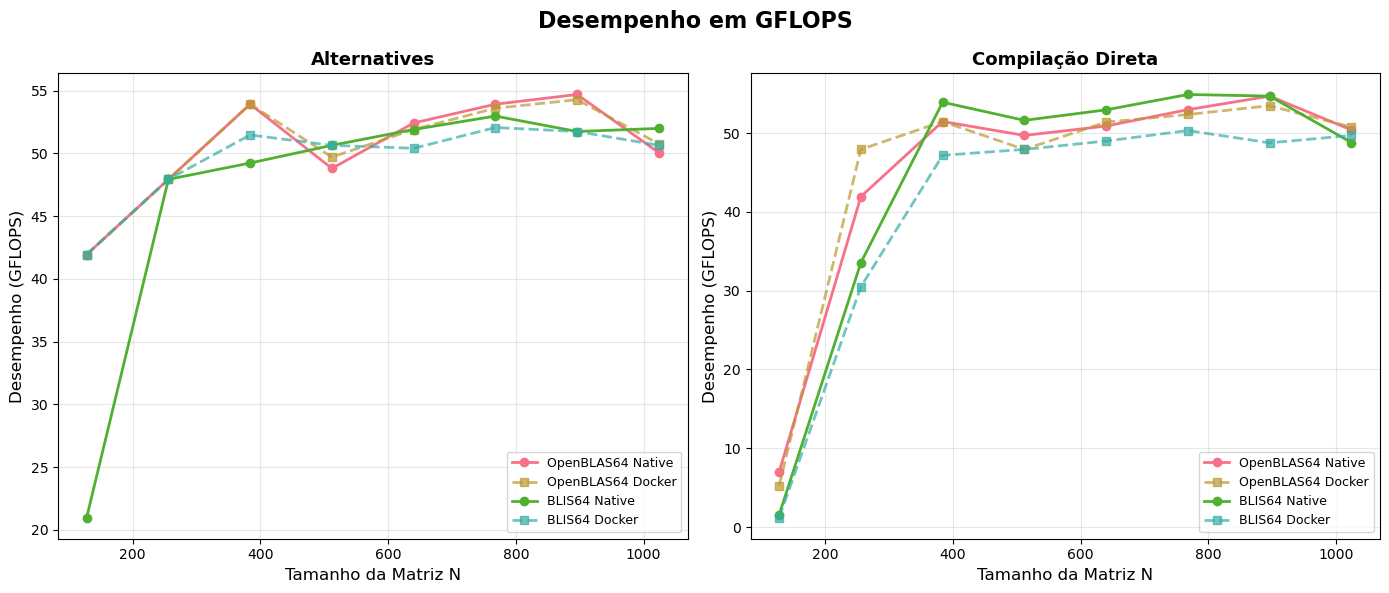


Tabela de Resumo:


T_native (s)  T_docker (s)  Overhead_tempo (%)  \
variant    method                                                               
BLIS64     alternatives              0.0131        0.0133             -5.8700   
           direct_compilation        0.0135        0.0142             11.1411   
OpenBLAS64 alternatives              0.0130        0.0130             -0.1076   
           direct_compilation        0.0132        0.0132              3.2891   

                               GFLOPS_native  GFLOPS_docker  \
variant    method                                             
BLIS64     alternatives              47.1787        49.6099   
           direct_compilation        44.0038        40.5790   
OpenBLAS64 alternatives              50.4657        50.5111   
           direct_compilation        44.8892        45.0758   

                               Overhead_GFLOPS (%)  Slowdown  
variant    method                                             
BLIS64     alternatives                   -12.1678    0.9413  
           direct_compilation               9.5496    1.1114  
OpenBLAS64 alternatives                    -0.1167    0.9989  
           direct_compilation               1.9978    1.0329


✓ Tabelas salvas em ../tabelas/


In [11]:
# Gerar tabelas e gráficos para visualização dos resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

# Criar diretórios
Path('../figuras').mkdir(exist_ok=True)
Path('../tabelas').mkdir(exist_ok=True)

# Gráfico 1: Overhead vs Tamanho da Matriz
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Overhead de Tempo: Docker vs Nativo', fontsize=16, fontweight='bold')

for idx, method in enumerate(methods):
    ax = axes[idx]
    for variant in variants:
        mask = (df_pivot['variant'] == variant) & (df_pivot['method'] == method)
        data = df_pivot[mask].sort_values('matSize')
        ax.plot(data['matSize'], data['overhead_tempo_percent'], 
                marker='o', label=variant, linewidth=2, markersize=6)
    
    method_title = 'Alternatives' if method == 'alternatives' else 'Compilação Direta'
    ax.set_xlabel('Tamanho da Matriz N', fontsize=12)
    ax.set_ylabel('Overhead de Tempo (%)', fontsize=12)
    ax.set_title(f'{method_title}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../figuras/overhead_tempo.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 2: Comparação de GFLOPS
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Desempenho em GFLOPS', fontsize=16, fontweight='bold')

for idx, method in enumerate(methods):
    ax = axes[idx]
    for variant in variants:
        mask = (df_pivot['variant'] == variant) & (df_pivot['method'] == method)
        data = df_pivot[mask].sort_values('matSize')
        ax.plot(data['matSize'], data['gflops_native'], marker='o', 
                label=f'{variant} Native', linewidth=2)
        ax.plot(data['matSize'], data['gflops_docker'], marker='s', 
                label=f'{variant} Docker', linewidth=2, linestyle='--', alpha=0.7)
    
    method_title = 'Alternatives' if method == 'alternatives' else 'Compilação Direta'
    ax.set_xlabel('Tamanho da Matriz N', fontsize=12)
    ax.set_ylabel('Desempenho (GFLOPS)', fontsize=12)
    ax.set_title(f'{method_title}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../figuras/desempenho_gflops.png', dpi=300, bbox_inches='tight')
plt.show()

# Tabela de resumo
summary_table = df_pivot.groupby(['variant', 'method']).agg({
    'native': 'mean',
    'docker': 'mean',
    'overhead_tempo_percent': 'mean',
    'gflops_native': 'mean',
    'gflops_docker': 'mean',
    'overhead_gflops_percent': 'mean',
    'slowdown': 'mean'
}).round(4)

summary_table.columns = ['T_native (s)', 'T_docker (s)', 'Overhead_tempo (%)', 
                          'GFLOPS_native', 'GFLOPS_docker', 'Overhead_GFLOPS (%)', 'Slowdown']

print("\nTabela de Resumo:")
display(summary_table)

# Salvar tabelas
summary_table.to_csv('../tabelas/resumo_overhead.csv')
summary_table.to_latex('../tabelas/resumo_overhead.tex', float_format="%.4f")
print("\n✓ Tabelas salvas em ../tabelas/")

## 6. Conclusões Possíveis

Com base nessa metodologia, é possível responder a questões como:

- Existe overhead mensurável ao usar Docker para aplicações de alto desempenho baseadas em DGEMM?
- Esse overhead depende do tamanho da matriz \( N \)?
- O overhead aumenta ou diminui com o número de *threads*?
- Diferentes implementações de BLAS são mais ou menos sensíveis ao uso de Docker?

A combinação de métricas quantitativas (overhead de tempo e de GFLOPS) com análise estatística confere rigor ao estudo
e permite conclusões bem fundamentadas em um contexto de HPC.


In [12]:
# Sumarizar resultados e gerar artefatos finais para o TCC

# Salvar tabela detalhada
detailed_table = df_pivot[['variant', 'method', 'matSize', 'native', 'docker',
                           'overhead_tempo_percent', 'overhead_tempo_abs',
                           'gflops_native', 'gflops_docker', 'overhead_gflops_percent',
                           'slowdown']].copy()

detailed_table.columns = ['BLAS', 'Método', 'N', 'T_host (s)', 'T_dock (s)',
                          'OH_tempo (%)', 'OH_abs (s)', 'P_host (GFLOPS)', 
                          'P_dock (GFLOPS)', 'OH_GFLOPS (%)', 'Slowdown']

detailed_table.to_csv('../tabelas/resultados_detalhados.csv', index=False, float_format='%.6f')
detailed_table.to_latex('../tabelas/resultados_detalhados.tex', index=False, float_format="%.6f")

# Salvar estatísticas
overhead_stats.to_csv('../tabelas/estatisticas_overhead.csv')

# Resumo final
overall_overhead = df_pivot['overhead_tempo_percent'].mean()
overall_gflops_loss = df_pivot['overhead_gflops_percent'].mean()

print("="*80)
print("RESUMO FINAL PARA TCC")
print("="*80)
print(f"\n• Overhead médio de tempo: {overall_overhead:.2f}%")
print(f"• Overhead médio de GFLOPS: {overall_gflops_loss:.2f}%")
print(f"• Slowdown médio: {df_pivot['slowdown'].mean():.4f}x")

if abs(overall_overhead) < 1.0:
    print("\n✅ CLASSIFICAÇÃO: DESPREZÍVEL (<1%)")
    print("   Docker é RECOMENDADO para desenvolvimento E produção HPC")
elif abs(overall_overhead) < 3.0:
    print("\n✅ CLASSIFICAÇÃO: ACEITÁVEL (<3%)")
    print("   Docker é VIÁVEL para desenvolvimento, testes e produção")
else:
    print("\n⚠️  CLASSIFICAÇÃO: SIGNIFICATIVO (≥3%)")
    print("   Docker deve ser usado com cautela em produção HPC")

print("\n📊 Artefatos gerados:")
print("   • Figuras: ../figuras/ (overhead_tempo.png, desempenho_gflops.png)")
print("   • Tabelas: ../tabelas/ (resumo_overhead.csv/.tex, resultados_detalhados.csv/.tex)")
print("="*80)

RESUMO FINAL PARA TCC

• Overhead médio de tempo: 2.11%
• Overhead médio de GFLOPS: -0.18%
• Slowdown médio: 1.0211x

✅ CLASSIFICAÇÃO: ACEITÁVEL (<3%)
   Docker é VIÁVEL para desenvolvimento, testes e produção

📊 Artefatos gerados:
   • Figuras: ../figuras/ (overhead_tempo.png, desempenho_gflops.png)
   • Tabelas: ../tabelas/ (resumo_overhead.csv/.tex, resultados_detalhados.csv/.tex)
